In [24]:
%matplotlib inline

In [2]:
# Imports

# project 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf

# project 2
# import pygame
import sys
from copy import deepcopy
# from mcts import *

import math
import random

# Monte Carlo Simulation

Resources
* Monte Carlo Simulation [wikipedia page](https://en.wikipedia.org/wiki/Monte_Carlo_method)
* Monte Carlo Simulation [youtube video](https://www.youtube.com/watch?v=OgO1gpXSUzU&t=2583s)
* Monte Carlo Tree Search [wikipedia page](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search)
* Monte Carlo Tree Search [youtube video](https://www.youtube.com/watch?v=UXW2yZndl7U)

## Abstract
The purpose of Monte Carlo simulation(MCS) is to simulate a real life experiment that depends on randomness to some extent.The applications of MCS which we are going to implement are 'Finance and bussiness' and 'Artificial Inteligence for games'. We will make a simulation of a stock portfolio out to 100 days using financial data from yahoo. We will also make the Tic Tac Toe game, where we play against an AI based on the Monte Carlo Tree Search(MCTS) algorithm. The MCTS algorithm figures out the best move out of a set of moves by Selecting → Expanding → Simulating → Updating the nodes in tree to find the final solution.

## 1. Introduction
Monte Carlo simulation, or Monte Carlo methods, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. In a few words, the purpose of Monte Carlo is to simulate a real life experiment that depends on randomness to some extent.
Monte Carlo simulation is widely used across various industries. Some areas of application include:
* Physical sciences
* Engineering
* Artificial intelligence for games
* Computer graphics
* Finance and business
* Law

In this documentation, I will show you two examples of Monte Carlo simulation (Finance and business, Artificial intelligence for games).

## 2. Simulated Stock Portolio
We are going to make a simulation of a stock portfolio out to 100 days and we are going to track that over time.

Firstly we will make a function, which will import our financial data from yahoo and compute the mean returns and covariance matrix.

In [8]:
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix
yf.pdr_override()

Now we will define our stocks. After that we will add the string '.AX' after every single stock, because yahoo requires .AX at the end of all Australian stocks.

In [9]:
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]

We also need to define a start and end date.

In [10]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=300)

Now we will get the mean returns and the covariance matrix using our get_data function.

In [11]:
meanReturns, covMatrix = get_data(stocks, start_date, end_date)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  6 of 6 completed


The only thing left is to implement the Monte Carlo method.

In [12]:
# Monte Carlo Method
mc_sims = 1000 # number of simulations
T = 100 # timeframe in days

We will define some empty arrays that we are going to store and retrieve information from. One of these arrays is going to be mean returns in the format of the number of days(meanM). The other array is going to be the one we are going to store information in(portfolio_sims).

In [13]:
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000 # Initial portfolio value

We will be assuming daily returns are distributed by a Multivariate Normal Distribution. 
$$ Rt∼MVN(μ,∑) $$

Cholesky Decomposition is used to determine Lower Triangular Matrix.
$$ L∈LL′=∑ $$
$$ Rt=μ+LZt $$ 
$$ Zt∼N(0,I) $$
Where $ Zt $ are the samples from a normal distribution.

As we run through this iteration we will use the formula shown above to be able to work out the daily returns. So we are taking a bunch of uncorrelated sample data that we sample from the normal distribution and we are correlating them with the covariance matrix through the use of this lower triangle L

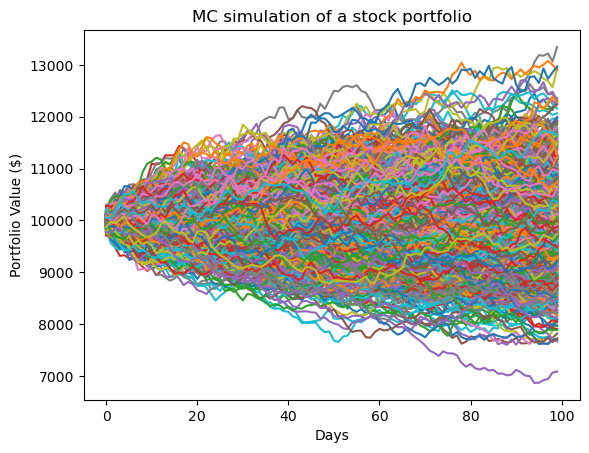

In [16]:
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))# uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) # Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) # Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

## 3. Tic Tac Toe
We will be creating the Tic Tac Toe game, where we play against an AI based on Monte Carlo Tree Search (MCTS). 
What is Monte Carlo Tree Search? 
>MCTS is an algorithm that figures out the best move out of a set of moves by Selecting → Expanding → Simulating → Updating the nodes in tree to find the final solution. This method is repeated until it reaches the solution and learns the policy of the game.
These 4 phases are called: Tree Traversal, Node expansion, Rollout (random simulation) and Backpropagation.                     


* The Tree Traversal phase uses the UCB1 formula:
$$ UCB1(Si) =  V_{i} + C \sqrt{\frac{ln N}{n_{i}}}, C = 2 $$
* The Node expansion phase adds extra nodes into the tree.
* The Rollout phase is where you do a random simulation of the game in order to find a value.
* The Backpropagation phase which is where you take the value found from the Rollout phase and you put that in appropriate places in the tree, all the way up to the top node.

This is the algorithm for Tree Traversal and Node Expansion phase:
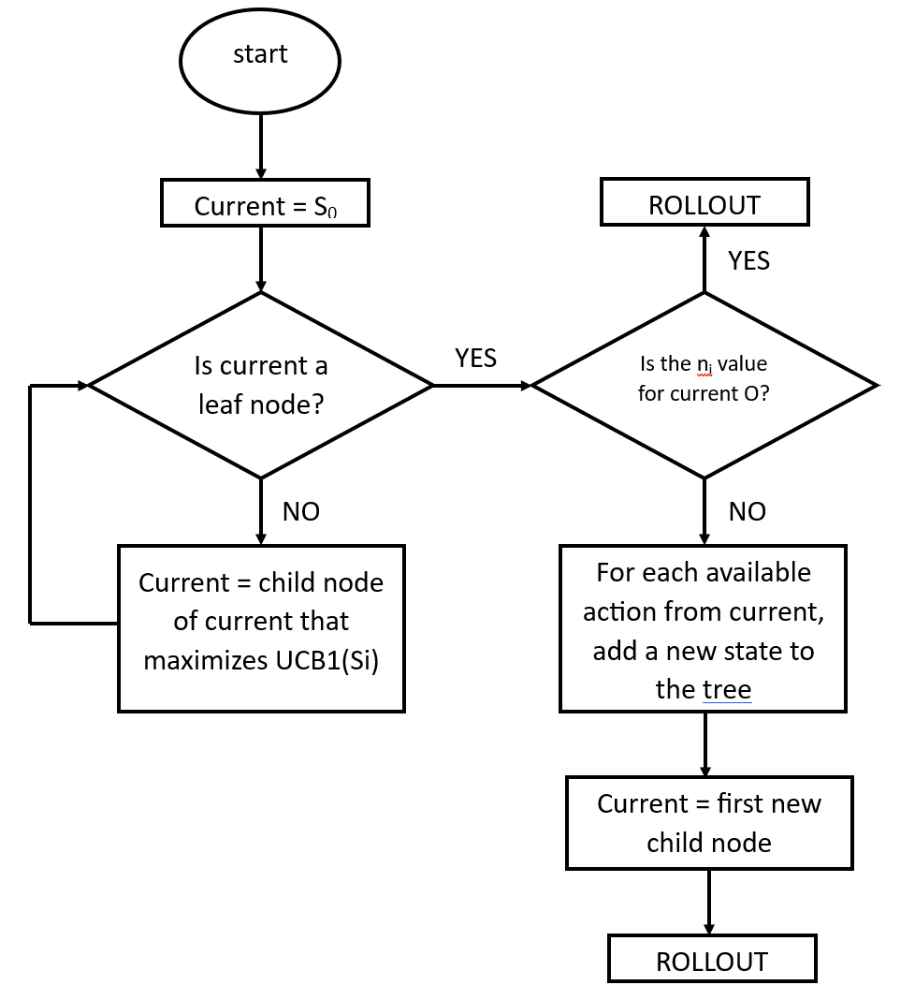

And this is the Rollout process:

    Rollout(Si):
        loop forever:
            if Si is a terminal state:
                return value(Si)
            Ai = random(available-actions(Si))
            Si = simulate(Ai, Si)
          
Now that you know a little bit about MCTS let's start with coding the actual game - Tic Tac Toe.

The packages we will use are: 
* pygame for the visualisation of our game .
* sys for the sys.exit() function.When called, the sys.exit() function will raise a SystemExit exception signaling an intention to exit the interpreter.
* deepcopy to copy the instance of the entire board class in case we need to generate a node for our opponent.
* mcts(python folder) which we have not coded yet.

Firstly, we will set up pygame.

In [21]:
pygame.init()

# Width and height of the screen
WIDTH, HEIGHT = 300, 300

# Square size of the board
ROWS, COLS = 3, 3
SQUARE_SIZE = WIDTH // COLS

# Colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREY = (63, 66, 74)

font = pygame.font.SysFont('freesansbold.ttf', 40)

# Initialize Pygame
pygame.init()
WINDOW = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Tic Tac Toe")

Secondly, we will define the Tic Tac Toe board class.

In [22]:
# Tic Tac Toe board class
class Board:
    def __init__(self, board=None):
        # define players
        self.player_1 = 'x'
        self.player_2 = 'o'
        self.empty_square = '.'
        self.game_over = False

        # define board position
        self.position = {}

        # init (reset) board
        self.init_board()

        # create a copy of a previous board state if available
        if board is not None:
            self.__dict__ = deepcopy(board.__dict__)
            
    def init_board(self):
        # loop over board rows
        for row in range(3):
            # loop over board columns
            for col in range(3):
                # set every board square to empty square
                self.position[row, col] = self.empty_square

Then we will add some additional methods to the Tic Tac Toe board class.

In [23]:
    def draw_board(self):
        for row in range(ROWS):
            for col in range(COLS):
                # pygame.draw.rect(WINDOW, WHITE, (col * SQUARE_SIZE, row * SQUARE_SIZE, SQUARE_SIZE, SQUARE_SIZE))
                if self.position[row, col] == 'o':
                    pygame.draw.circle(WINDOW, GREY, (col * SQUARE_SIZE + SQUARE_SIZE // 2, row * SQUARE_SIZE + SQUARE_SIZE // 2), SQUARE_SIZE // 4)
                elif self.position[row, col] == 'x':
                    pygame.draw.line(WINDOW, GREY, (col * SQUARE_SIZE + SQUARE_SIZE // 4, row * SQUARE_SIZE + SQUARE_SIZE // 4),
                                        (col * SQUARE_SIZE + SQUARE_SIZE - SQUARE_SIZE // 4, row * SQUARE_SIZE + SQUARE_SIZE - SQUARE_SIZE // 4), 3)
                    pygame.draw.line(WINDOW, GREY, (col * SQUARE_SIZE + SQUARE_SIZE // 4, row * SQUARE_SIZE + SQUARE_SIZE - SQUARE_SIZE // 4),
                                        (col * SQUARE_SIZE + SQUARE_SIZE - SQUARE_SIZE // 4, row * SQUARE_SIZE + SQUARE_SIZE // 4), 3)

The draw_board method will draw the current position of the board(the placement of "X" and "O") on the screen. Next we will add another method which will draw the grid of the board.

In [24]:
    @staticmethod
    def draw_board_grid(screen, screen_width, screen_height, line_width):
        grid = (50, 50, 50)
        for x in range(1, 3):
            pygame.draw.line(screen, grid, (0, 100 * x), (screen_width, 100 * x), line_width)
            pygame.draw.line(screen, grid, (100 * x, 0), (100 * x, screen_height), line_width)

Then we will add a method which will be used from both players to make moves.

In [25]:
    # make move
    def make_move(self, row, col):
        # create new board instance that inherits from the current state
        board = Board(self)

        # make move
        board.position[row, col] = self.player_1

        # swap players
        (board.player_1, board.player_2) = (board.player_2, board.player_1)

        # return new board state
        return board

The next methods will be the is_draw() method wich will check if the game is drawn and the is_win() method which will check if the game is won by one of the players.

In [1]:
# get whether the game is drawn
    def is_draw(self):
        # loop over board squares
        for row, col in self.position:
            # empty square is available
            if self.position[row, col] == self.empty_square:
                # this is not a draw
                return False

        # by default we return a draw
        self.game_over = True
        return True
    
    def is_win(self):
        # vertical sequence detection
        # loop over board columns
        for col in range(3):
            # define winning sequence list
            winning_sequence = []

            # loop over board rows
            for row in range(3):
                # if found same next element in the row
                if self.position[row, col] == self.player_2:
                    # update winning sequence
                    winning_sequence.append((row, col))

                # if we have 3 elements in the row
                if len(winning_sequence) == 3:
                    # return the game is won state
                    self.game_over = True
                    return True

        # horizontal sequence detection
        # loop over board columns
        for row in range(3):
            # define winning sequence list
            winning_sequence = []

            # loop over board rows
            for col in range(3):
                # if found same next element in the row
                if self.position[row, col] == self.player_2:
                    # update winning sequence
                    winning_sequence.append((row, col))

                # if we have 3 elements in the row
                if len(winning_sequence) == 3:
                    # return the game is won state
                    return True

        # 1st diagonal sequence detection
        # define winning sequence list
        winning_sequence = []

        # loop over board rows
        for row in range(3):
            # init column
            col = row

            # if found same next element in the row
            if self.position[row, col] == self.player_2:
                # update winning sequence
                winning_sequence.append((row, col))

            # if we have 3 elements in the row
            if len(winning_sequence) == 3:
                # return the game is won state
                return True

        # 2nd diagonal sequence detection
        # define winning sequence list
        winning_sequence = []

        # loop over board rows
        for row in range(3):
            # init column
            col = 3 - row - 1

            # if found same next element in the row
            if self.position[row, col] == self.player_2:
                # update winning sequence
                winning_sequence.append((row, col))

            # if we have 3 elements in the row
            if len(winning_sequence) == 3:
                # return the game is won state
                return True

        # by default return non winning state
        return False

The next two methods will be the get_empty_squares method which gives you a list of the empty squares and the is_board_full method which checks if the board is full(no empty squares).

In [27]:
    def get_empty_squares(self):
        empty_squares = []
        for row in range(ROWS):
            for col in range(COLS):
                if self.position[row, col] == ".":
                    empty_squares.append((row, col))
        return empty_squares

    def is_board_full(self):
        return len(self.get_empty_squares()) == 0

Now we will add the main game loop.

In [28]:
    # main game loop
    def game_loop(self):
        clock = pygame.time.Clock()
        mcts = MCTS() # we have not coded it yet

        while True:
            self.draw_board_grid(WINDOW, WIDTH, HEIGHT, 6)
            self.draw_board()

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
                
                # check if a key is pressed
                if event.type == pygame.KEYDOWN:
                    # check if escape key is pressed
                    if event.type == pygame.K_ESCAPE:
                        pygame.quit()
                        sys.exit()
                
                # check if right mouse button is clicked
                if event.type == pygame.MOUSEBUTTONDOWN:
                    # get coordinates of the mouse
                    mouse_pos = pygame.mouse.get_pos()
                    col = mouse_pos[0] // SQUARE_SIZE
                    row = mouse_pos[1] // SQUARE_SIZE

                    # if self.position[row, col] != self.empty_square:
                    #     print(' Illegal move!')
                    #     continue
                    
                    # make move
                    if not self.game_over and not self.is_board_full():
                        self = self.make_move(row, col)

                    # AI's turn
                    if not self.game_over and not self.is_board_full():
                        best_move = mcts.search(self)

                        # make move
                        self = best_move.board


            # check if the game is won
            if self.is_win():
                
                # draw end text
                end_text = 'player "%s" has won the game!' % self.player_2
                end_img = font.render(end_text, True, RED)
                pygame.draw.rect(WINDOW, BLACK, (WIDTH // 2 - 100, HEIGHT // 2 - 60, 200, 50))
                WINDOW.blit(end_img, (WIDTH // 2 - 100, HEIGHT // 2 - 50))

            # check if the game is drawn
            elif self.is_draw():
                
                # draw end text
                end_text = 'Game is drawn!'
                end_img = font.render(end_text, True, RED)
                pygame.draw.rect(WINDOW, BLACK, (WIDTH // 2 - 100, HEIGHT // 2 - 60, 200, 50))
                WINDOW.blit(end_img, (WIDTH // 2 - 100, HEIGHT // 2 - 50))

            pygame.display.update()
            clock.tick(60)

We are done coding the game, now it is time to implement the MCTS algorithm.
For that we will need two packages(math, random).

Let's define the Tree Node class.

In [19]:
class TreeNode:
    # class constructor (create tree node class instance)
    def __init__(self, board, parent):
        # init associated board state
        self.board = board

        # init is node terminal flag
        if self.board.is_win() or self.board.is_draw():
            # we have a terminal node
            self.is_terminal = True

        # otherwise
        else:
            # we have a non-terminal node
            self.is_terminal = False

        # init is fully expanded flag
        self.is_fully_expanded = self.is_terminal

        # init parent node if available
        self.parent = parent

        # init the number of node visits
        self.visits = 0

        # init the total score of the node
        self.score = 0

        # init current node's children
        self.children = {}

Now the only think left is to define the MCTS class itself. We will add a search method, which will search for the best move; select method, which will select the most promising node; expand method, which we'll use for expanding nodes; rollout method for simulating the game; backpropagate method, which will backpropagate the number of visits and score up to the root node;
get_best_move method, which will select the best node basing on UCB1 formula.

In [20]:
class MCTS:
    # search for the best move in the current position
    def search(self, initial_state):
        # create root node
        self.root = TreeNode(initial_state, None)

        # walk through 1000 iterations
        for iteration in range(1000):
            # ----> select a node (selection phase)
            node = self.select(self.root)

            # ----> scrore current node (simulation phase)
            score = self.rollout(node.board)

            # ----> backpropagate results
            self.backpropagate(node, score)

        # pick up the best move in the current position
        try:
            return self.get_best_move(self.root, 0)

        except:
            pass

    # select most promising node
    def select(self, node):
        # make sure that we're dealing with non-terminal nodes
        while not node.is_terminal:
            # case where the node is fully expanded
            if node.is_fully_expanded:
                node = self.get_best_move(node, 2)

            # case where the node is not fully expanded
            else:
                # otherwise expand the node
                return self.expand(node)

        # return node
        return node

    # expand node
    @staticmethod
    def expand(node):
        # generate legal states (moves) for the given node
        states = node.board.generate_states()

        # loop over generated states (moves)
        for state in states:
            # make sure that current state (move) is not present in child nodes
            if str(state.position) not in node.children:
                # create a new node
                new_node = TreeNode(state, node)

                # add child node to parent's node children list (dict)
                node.children[str(state.position)] = new_node

                # case when node is fully expanded
                if len(states) == len(node.children):
                    node.is_fully_expanded = True

                # return newly created node
                return new_node

    # simulate the game via making random moves until reach end of the game
    def rollout(self, board):
        # make random moves for both sides until terminal state of the game is reached
        while not board.is_win():
            # try to make a move
            try:
                # make the on board
                board = random.choice(board.generate_states())

            # no moves available
            except:
                # return a draw score
                return 0

        # return score from the player "x" perspective
        if board.player_2 == 'x':
            return 1
        elif board.player_2 == 'o':
            return -1

    # backpropagate the number of visits and score up to the root node
    def backpropagate(self, node, score):
        # update nodes's up to root node
        while node is not None:
            # update node's visits
            node.visits += 1

            # update node's score
            node.score += score

            # set node to parent
            node = node.parent

    # select the best node basing on UCB1 formula
    def get_best_move(self, node, exploration_constant):
        # define best score & best moves
        best_score = float('-inf')
        best_moves = []

        # loop over child nodes
        for child_node in node.children.values():
            # define current player
            if child_node.board.player_2 == 'x':
                current_player = 1
            elif child_node.board.player_2 == 'o':
                current_player = -1

            # get move score using UCT formula
            move_score = current_player * child_node.score / child_node.visits + exploration_constant * math.sqrt(
                math.log(node.visits / child_node.visits))

            # better move has been found
            if move_score > best_score:
                best_score = move_score
                best_moves = [child_node]

            # found as good move as already available
            elif move_score == best_score:
                best_moves.append(child_node)

        # return one of the best moves randomly
        return random.choice(best_moves)

## Summary 
As you’ve seen Monte Carlo simulation and Monte Carlo Tree Search are basically very easy to implement. But both of them have their disadvanteges too. MCS's disadvantages are that it is Computationally inefficient (when you have a large amount of variables bounded to different constraints, it requires a lot of time and a lot of computations to approximate a solution using this method) and if poor parameters and constraints are input into the model then poor results will be given as outputs. Some of MCTS's disadvanteges are that the algorithm needs a huge number of iterations to be able to effectively decide the most efficient path and as the tree growth becomes rapid after a few iterations, it might require a huge amount of memory.

After reading this documentation I hope you understand the core concept of MCS and MCTS.